# WISONet δD Retrievals
This notebook demonstrates how averaging kernels and a priori values affect satellite δD retrievals.


In [117]:
!curl -L "https://rice.box.com/shared/static/bcoy3ob0dme3umpurqmf0p6o48bznkj1" -o SWING3_2006_subset.nc
!curl -L "https://rice.box.com/shared/static/uuy9m15qc1p7s4wm1yrzfzxc6knx7hzw" -o TES_monthly_5deg_strict.nc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--  8000
100 12.7M  100 12.7M    0     0  6217k      0  0:00:02  0:00:02 --:--:-- 51.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    10    0    10    0     0      9      0 --:--:--  0:00:01 --:--:-- 10000
100 3095M  100 3095M    0     0  40.6M      0  0:01:16  0:01:16 --:--:-- 41.2M


In [118]:
!ls -lh


total 3.1G
drwxr-xr-x 1 root root 4.0K Jun 11 13:37 sample_data
-rw-r--r-- 1 root root  13M Jun 12 21:33 SWING3_2006_subset.nc
-rw-r--r-- 1 root root 3.1G Jun 12 21:35 TES_monthly_5deg_strict.nc


/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most x

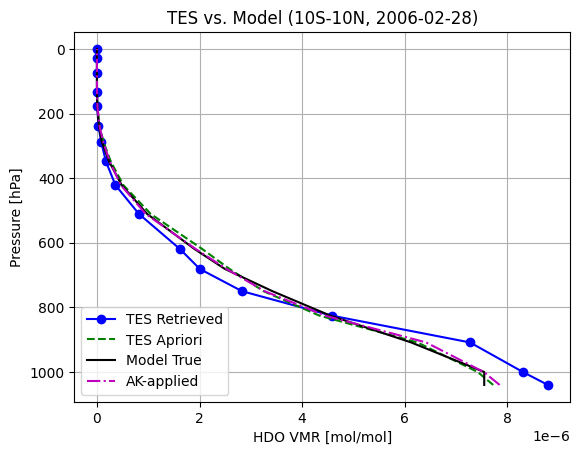

In [124]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar

# === User-defined month ===
user_month = 2  # CHANGE THIS (1 = January, 12 = December)
m = user_month - 1  # 0-based index for SWING3

# === Construct last day of month string ===
last_day = calendar.monthrange(2006, user_month)[1]
user_date_str = f'2006-{user_month:02d}-{last_day}'
target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

# === Load SWING3 ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values
month = ds['month'].values
dD = ds['dD'].values.astype(float)
q = ds['q'].values.astype(float)

# === Mask out fill values ===
dD[dD == -999] = np.nan
q[q == -999] = np.nan

# === Subset latitude range [-10, 10] ===
lat_mask = (lat >= -10) & (lat <= 10)
dD_eq = dD[m, :, lat_mask, :]  # [month, level, lat, lon]
q_eq  = q[m, :, lat_mask, :]

# === Average over lon and lat ===
dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

# === Constants ===
Rvsmow = 3.1152e-4
M_air = 28.9647
M_H2O = 18.01528

# === Convert q from mass to VMR ===
q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

# === Load TES ===
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

# === Time matching ===
base_date = datetime(2000, 1, 1)
if np.issubdtype(tes_time.dtype, np.datetime64):
    t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
else:
    target_days = (target_date - base_date).days
    t_tes = np.argmin(np.abs(tes_time - target_days))

# === Spatial subset: Equatorial Pacific [-10,10] ===
ilat_tes = np.where((tes_lat >= -10) & (tes_lat <= 10))[0]
ilon_tes = np.arange(len(tes_lon))

HDO_ret = sat['HDO_vmr'].values
HDO_a   = sat['HDO_ConstraintVector'].values
AK      = sat['AK_HDO'].values

lat_mask = (tes_lat >= -10) & (tes_lat <= 10)
HDO_ret = HDO_ret[t_tes, :, lat_mask, :]
HDO_a   = HDO_a[t_tes, :, lat_mask, :]
AK      = AK[t_tes, :, :, lat_mask, :]

# === Mask invalid values ===
HDO_ret[HDO_ret == -999] = np.nan
HDO_a[HDO_a == -999] = np.nan
AK[AK == -999] = np.nan

# === Average over lat and lon ===
HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

# === Interpolate model to TES pressure ===
HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])

# === Apply AK ===
ln_true = np.log(HDO_vmr1_interp)
ln_apriori = np.log(HDO_a_avg)
ln_smoothed = ln_apriori + AK_avg @ (ln_true - ln_apriori)
HDO_recon = np.exp(ln_smoothed)

# === Plot ===
plt.figure()
plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title(f'TES vs. Model (10S-10N, {user_date_str})')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
